`datalad get derivatives/freesurfer/sub-*/label/*.aparc.a2009s.annot derivatives/freesurfer/sub-*/surf/*.thickness`

In [1]:
from neurotools.transform.network import gen_fs_subj_vertex_network
import numpy as np
import os
from os.path import dirname, abspath

In [2]:
# Useful directories
main_dr = dirname(abspath(os.getcwd()))
data_dr = os.path.join(main_dr, 'data')
deriv_dr = os.path.join(data_dr, 'ds003097', 'derivatives')
save_dr = os.path.join(deriv_dr, 'fs_networks')

In [3]:
def proc_subj(subj_dr, modality='thickness'):
        
    # Get subject name from path
    subj_name = os.path.basename(subj_dr)
    
    # Gen subject save folder + loc
    subj_save_dr = os.path.join(save_dr, subj_name)
    os.makedirs(subj_save_dr, exist_ok=True)
    save_loc = os.path.join(subj_save_dr, modality + '.npy')
    
    # Skip if already processed
    if os.path.exists(save_loc):
        return save_loc

    # Gen network
    network = gen_fs_subj_vertex_network(subj_dr, modality=modality,
                                         discard_diagonal=True, vectorize=True)

    
    # Save
    np.save(save_loc, network)
    
    return save_loc

In [4]:
# Get all subject directory paths
fs_dr = os.path.join(deriv_dr, 'freesurfer')
subj_drs = [os.path.join(fs_dr, s) for s in os.listdir(fs_dr) if 'sub-' in s]

In [5]:
# Process one example - make sure works
save_loc = proc_subj(subj_drs[0])

ex_network = np.load(save_loc)
ex_network.shape

(11026,)

Now, with multi-processing, process all subject's data. Note: this is not a particularlly fast operation, for convience, functionality to start and stop has been added to the function, that is to say, the function will skip any that have already been processed so that this function can be started and stopped.

In [6]:
from joblib import Parallel, delayed
paths = Parallel(n_jobs=-1)(delayed(proc_subj)(subj_dr) for subj_dr in subj_drs)

We next want to make sure that all of the processed files are valid / comparible, as in some cases freesurfer will skip regions

In [7]:
# Load and get length of all
lens = np.array([np.load(path).shape[0] for path in paths])

# Keep only most common length
u_lens, cnts = np.unique(lens, return_counts=True)
keep_len = u_lens[np.argmax(cnts)]

# Remove
to_remove = np.array(paths)[lens != keep_len]
for path in to_remove:
    os.remove(path)

In [8]:
import BPt as bp

# Load the base template dataframe with targets loaded
data = bp.read_pickle(os.path.join(data_dr, 'datasets', 'template.dataset'))
data.shape

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


(928, 5)

In [9]:
# We use file globbing here to specify which files we want to 'load'
files = {'thick_network_edges': os.path.join(save_dr, 'sub-*', 'thickness.npy')}

# Add as data files
data = data.add_data_files(files, file_to_subject='auto')

# Drop any subjects with missing data file
data = data.drop_subjects_by_nan(scope='data')

data

Setting NaN threshold to: 0.5
Dropped 1 Rows


,thick_network_edges
participant_id,
sub-0001,Loc(556)
sub-0002,Loc(808)
sub-0003,Loc(283)
sub-0004,Loc(820)
sub-0005,Loc(312)
...,...
sub-0924,Loc(815)
sub-0925,Loc(444)
sub-0926,Loc(555)


thick_network_edges: 927 rows


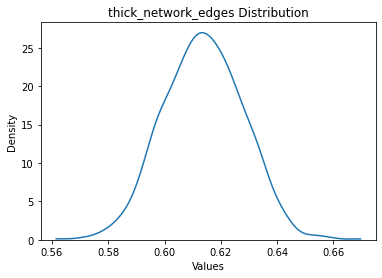

In [12]:
# Plot mean values of edge weights
data.plot(scope='data')

In [13]:
# Lastly, save the dataset
data.to_pickle(os.path.join(data_dr, 'datasets', 'fs_thick_network.dataset'))